In [8]:
from sentinelhub import SHConfig

In [24]:

config = SHConfig()
config.instance_id = '540fb133-7380-4f14-b661-d0bd70600af6'
config.sh_client_id = '9eb482a2-8adc-4d00-a9b9-2ba93fbb4a70'
config.sh_client_secret =  'KlTky6sua1whgt7ceQ2imzJUgxrqFaDV'


In [9]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest
import rasterio
import matplotlib.pyplot as plt
from rasterio.transform import from_origin
import geopandas as gpd
import pyproj
from shapely.geometry import LineString, box, Point
from shapely.affinity import scale
from rasterio.features import geometry_mask, rasterize
import folium
import pandas as pd

### Functions

In [10]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [11]:
def get_data_request(time_interval, evalscript):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.LANDSAT_OT_L1,
                time_interval=time_interval,
                mosaicking_order='leastCC',
                maxcc=0.1
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=size,
        data_folder="../data/raw/lst",
        config=config
    )

In [12]:
def first_day(month, year):
    return datetime.date(year, month, 1)

def last_day(any_day):
    # The day 28 exists in every month. 4 days later, it's always next month
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtracting the number of the current day brings us back one month
    return next_month - datetime.timedelta(days=next_month.day)


In [13]:
def find_closest_point(points_gdf, quadrant_bbox):
    lat_min, lon_min, lat_max, lon_max = quadrant_bbox

    # Filtrar puntos dentro del cuadrante
    points_in_quadrant = points_gdf.cx[lon_min:lon_max, lat_min:lat_max]

    # Si hay al menos un punto en el cuadrante, devolver el primero encontrado
    if not points_in_quadrant.empty:
        closest_points = points_gdf[points_gdf.geometry.isin(points_in_quadrant.geometry)]
        return closest_points
        #return points_in_quadrant.iloc[0]  # Devuelve el primer punto encontrado

    # Si no hay puntos en el cuadrante, encontrar el punto más cercano fuera del cuadrante
    # Calcular el centro del cuadrante
    center_x = (lat_min + lat_max) / 2
    center_y = (lon_min + lon_max) / 2
    center_point = Point(center_y, center_x)


    # Calculate distances from the center of the quadrant to all points
    distances = points_gdf.geometry.apply(lambda p: p.distance(center_point))

    # Find the minimum distance
    min_distance = distances.min()

    # Filter points that match the minimum distance
    closest_points = points_gdf[distances == min_distance]


    return closest_points

## Obtain LST images

Load the water temperature database filtered by dates and regions.

In [14]:
gdf_points = gpd.read_file('../data/external/wt_filtered/wt_filtered.geojson')

In [15]:
gdf_points.describe()

,time,longitude,latitude,waterTemperature
count,172044,172044.000000,172044.000000,172044.000000
mean,2015-07-16 05:33:20,8.208333,46.791667,7.913892
min,2011-01-31 00:00:00,5.791666,45.708332,0.100000
25%,2013-04-22 12:00:00,6.958334,46.208332,2.198152
50%,2015-07-15 12:00:00,8.208333,46.791668,6.564645
75%,2017-10-07 18:00:00,9.458333,47.375000,12.818750
max,2019-12-31 00:00:00,10.625000,47.875000,26.724939
std,NaN,1.419120,0.649075,6.369109


In [60]:
unique_dates = gdf_points.time.dt.strftime('%Y-%m').unique()

In [61]:
unique_dates

array(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', 

To specify different time slots

In [ ]:
start_date = '2013-03'
end_date = '2023-07'

# Generar el rango de fechas en formato YYYY-MM
date_range = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m')

# Convertir a un array de numpy (opcional, si quieres un array en lugar de un pandas Index)
unique_dates = date_range.to_numpy()
unique_dates

array(['2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12', 

#### Le boiron specificactions

In [18]:
boiron = gpd.read_file('../data/external/swissTLMboiron')
boiron = boiron.to_crs("EPSG:4326")
bounds = boiron.total_bounds


In [19]:
lon_min, lat_min, lon_max, lat_max = boiron.total_bounds

print(f"Coordenadas mínimas (longitud, latitud): {lon_min, lat_min}")
print(f"Coordenadas máximas (longitud, latitud): {lon_max, lat_max}")


Coordenadas mínimas (longitud, latitud): (6.3750888087611735, 46.48057742931898)
Coordenadas máximas (longitud, latitud): (6.49259460373858, 46.580193541005535)


In [20]:
# Exemple de BBOX sur le Boiron:
coords_wgs84 = [lon_min, lat_min, lon_max, lat_max]
resolution = 30

bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

# extract the size based on bbx and the resolution
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {size} pixels')

Image shape at 30 m resolution: (312, 359) pixels


#### Evalscript and sentinelhub request

In [21]:
evalscript_lst = """
    //VERSION=3 (auto-converted from 1)
    //// STARTING OPTIONS
    // choose on basis of which band (B10 or B11) LST mapping will be done
    var band = "B10";

    // for analysis of one image (OE Browser), choose option=0. In case of MULTI-TEMPORAL analyis, option values are following:
    // 0 - outputs average LST in selected timeline (% of cloud coverage should be low, e.g. < 10%)
    // 1 - outputs maximum LST in selected timeline (% of cloud coverage can be high)
    // 2 - outputs standard deviation LST in selected timeline; minTemp and highTemp are overwritten with values 0 and 10 (% of cloud coverage should be low, e.g. < 5%)
    var option = 0;

    // minimum and maximum values for output colour chart red to white for temperature in °C. Option 2 overwrites this selection!
    var minC = 0;
    var maxC = 50;


    ////INPUT DATA - FOR BETTER RESULTS, THE DATA SHOULD BE ADJUSTED
    // NVDIs for bare soil and NDVIv for full vegetation
    // Note: NVDIs for bare soil and NDVIv for full vegetation are needed to be evaluated for every scene. However in the custom script, default values are set regarding:
    // https://profhorn.meteor.wisc.edu/wxwise/satmet/lesson3/ndvi.html
    // https://www.researchgate.net/post/Can_anyone_help_me_to_define_a_range_of_NDVI_value_to_extract_bare_soil_pixels_for_Landsat_TM
    // NVDIs=0.2, NDVIv=0.8
    // other source suggests global values: NVDIs=0.2, NDVIv=0.5; https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    var NDVIs = 0.2;
    var NDVIv = 0.8;

    // emissivity
    var waterE = 0.991;
    var soilE = 0.966;
    var vegetationE = 0.973;
    //var buildingE=0.962;
    var C = 0.009; //surface roughness, https://www.researchgate.net/publication/331047755_Land_Surface_Temperature_Retrieval_from_LANDSAT-8_Thermal_Infrared_Sensor_Data_and_Validation_with_Infrared_Thermometer_Camera

    //central/mean wavelength in meters, B10 or B11
    var bCent = (band == "B10") ? 0.000010895 : 0.000012005;

    // rho =h*c/sigma=PlanckC*velocityLight/BoltzmannC
    var rho = 0.01438; // m K

    //// visualization
    // if result should be std dev (option=2), overwrite minMaxC.
    if (option == 2) {
      minC = 0;
      maxC = 25;
    }
    let viz = ColorGradientVisualizer.createRedTemperature(minC, maxC);


    function setup() {
      return {
        input: [{
          bands: [
            "B03",
            "B04",
            "B05",
            "B10",
            "B11"
          ]
        }],
        mosaicking: "ORBIT",
        output: { bands: 3 }
      }
    }


    //emissivity calc
    //https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    //https://www.academia.edu/27239873/Investigating_Land_Surface_Temperature_Changes_Using_Landsat_Data_in_Konya_Turkey
    function LSEcalc(NDVI, Pv) {
      var LSE;
      if (NDVI < 0) {
        //water
        LSE = waterE;
      } else if (NDVI < NDVIs) {
        //soil
        LSE = soilE;
      } else if (NDVI > NDVIv) {
        //vegetation
        LSE = vegetationE;
      } else {
        //mixtures of vegetation and soil
        LSE = vegetationE * Pv + soilE * (1 - Pv) + C;
      }
      return LSE;
    }

    function evaluatePixel(samples) {
      // starting values max, avg, stdev, reduce N, N for multi-temporal
      var LSTmax = -999;
      var LSTavg = 0;
      var LSTstd = 0;
      var reduceNavg = 0;
      var N = samples.length;

      //to caputure all values of one pixel for for whole timeline in mosaic order
      var LSTarray = [];

      // multi-temporal: loop all samples in selected timeline
      for (var i = 0; i < N; i++) {
        //// for LST
        // B10 or B11
        var Bi = (band == "B10") ? samples[i].B10 : samples[i].B11;
        var B03i = samples[i].B03;
        var B04i = samples[i].B04;
        var B05i = samples[i].B05;

        // some images have errors, whole area is either B10<173K or B10>65000K. Also errors, where B04 and B05 =0. Therefore no processing if that happens, in addition for average and stdev calc, N has to be reduced!
        if ((Bi > 173 && Bi < 65000) && (B03i > 0 && B04i > 0 && B05i > 0)) {
          // ok image
          //1 Kelvin to C
          var b10BTi = Bi - 273.15;
          //2 NDVI - Normalized Difference vegetation Index
          var NDVIi = (B05i - B04i) / (B05i + B04i);
          //3 PV - proportional vegetation
          var PVi = Math.pow(((NDVIi - NDVIs) / (NDVIv - NDVIs)), 2);
          //4 LSE land surface emmisivity
          var LSEi = LSEcalc(NDVIi, PVi);
          //5 LST
          var LSTi = (b10BTi / (1 + (((bCent * b10BTi) / rho) * Math.log(LSEi))));

          ////temporary calculation
          //avg
          LSTavg = LSTavg + LSTi;
          //max
          if (LSTi > LSTmax) { LSTmax = LSTi; }
          //array
          LSTarray.push(LSTi);
        } else {
          // image NOT ok
          ++reduceNavg;
        }
      }
      // correct N value if some images have errors and are not analysed
      N = N - reduceNavg;

      // calc final avg value
      LSTavg = LSTavg / N;

      // calc final stdev value
      for (var i = 0; i < LSTarray.length; i++) {
        LSTstd = LSTstd + (Math.pow(LSTarray[i] - LSTavg, 2));
      }
      LSTstd = (Math.pow(LSTstd / (LSTarray.length - 1), 0.5));

      // WHICH LST to output, it depends on option variable: 0 for one image analysis (OE Browser); MULTI-TEMPORAL: 0->avg; 1->max; 2->stdev
      let outLST = (option == 0)
        ? LSTavg
        : (option == 1)
          ? LSTmax
          : LSTstd;

      //// output to image
      return viz.process(outLST);
    }
"""

In [22]:
slots = []

for date in unique_dates:
  year = int(date.split('-')[0])
  month = int(date.split('-')[1])
  fd = first_day(month, year)
  ld = last_day(fd)
  slots.append( (fd.isoformat(), ld.isoformat()) )

slots

[('2011-01-01', '2011-01-31'),
 ('2011-02-01', '2011-02-28'),
 ('2011-03-01', '2011-03-31'),
 ('2011-04-01', '2011-04-30'),
 ('2011-05-01', '2011-05-31'),
 ('2011-06-01', '2011-06-30'),
 ('2011-07-01', '2011-07-31'),
 ('2011-08-01', '2011-08-31'),
 ('2011-09-01', '2011-09-30'),
 ('2011-10-01', '2011-10-31'),
 ('2011-11-01', '2011-11-30'),
 ('2011-12-01', '2011-12-31'),
 ('2012-01-01', '2012-01-31'),
 ('2012-02-01', '2012-02-29'),
 ('2012-03-01', '2012-03-31'),
 ('2012-04-01', '2012-04-30'),
 ('2012-05-01', '2012-05-31'),
 ('2012-06-01', '2012-06-30'),
 ('2012-07-01', '2012-07-31'),
 ('2012-08-01', '2012-08-31'),
 ('2012-09-01', '2012-09-30'),
 ('2012-10-01', '2012-10-31'),
 ('2012-11-01', '2012-11-30'),
 ('2012-12-01', '2012-12-31'),
 ('2013-01-01', '2013-01-31'),
 ('2013-02-01', '2013-02-28'),
 ('2013-03-01', '2013-03-31'),
 ('2013-04-01', '2013-04-30'),
 ('2013-05-01', '2013-05-31'),
 ('2013-06-01', '2013-06-30'),
 ('2013-07-01', '2013-07-31'),
 ('2013-08-01', '2013-08-31'),
 ('2013-

Download the data

In [25]:
# create a list of requests
list_of_requests = [get_data_request(slot,evalscript_lst) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [26]:
len(data)

108

In [27]:
import os
import shutil

# Ruta de la carpeta que contiene las subcarpetas
source_folder = '../data/raw/lst'
# Ruta de la carpeta donde se guardarán los archivos .tiff renombrados
destination_folder = '../data/raw/lst'
os.makedirs(destination_folder, exist_ok=True)

# Inicializa un contador para renombrar las imágenes
counter = 0

for file in os.listdir(destination_folder):
    if file.endswith('.tiff'):
        os.remove(os.path.join(destination_folder, file))

In [28]:
# Recorre todas las subcarpetas en la carpeta principal
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        # Si el archivo es un .tiff
        if file.endswith('.tiff'):
            # Construye la ruta completa del archivo tiff
            tiff_file_path = os.path.join(subdir, file)

            # Define el nuevo nombre del archivo
            new_file_name = f'image_{slots[counter][0][:7]}.tiff'
            new_file_path = os.path.join(destination_folder, new_file_name)

            # Mueve el archivo al nuevo directorio con el nuevo nombre
            shutil.move(tiff_file_path, new_file_path)

            # Incrementa el contador
            counter += 1

In [29]:

for subdir, dirs, files in os.walk(source_folder):
    for dir in dirs:
        dir_path = os.path.join(subdir, dir)
        shutil.rmtree(dir_path, ignore_errors=True)

## Obtain WT images

Divide quadrants and link them to its closest point in the database. If there is a point in the quadrant, return it. Else, calculate the closest point with euclidian distance

In [30]:
# Define el bbox del cuadrado
bbox = [lat_min, lon_min, lat_max, lon_max]

# Calcula el centro de cada cuadrante
lat_mid = (lat_min + lat_max) / 2
lon_mid = (lon_min + lon_max) / 2

# Definir los cuadrantes como cajas de límites (bounding boxes)
quadrants = {
    'upper_left': [lat_mid, lon_min, lat_max, lon_mid],  # lat_max y lon_mid
    'upper_right': [lat_mid, lon_mid, lat_max, lon_max],  # lat_max y lon_max
    'lower_left': [lat_min, lon_min, lat_mid, lon_mid],  # lat_min y lon_mid
    'lower_right': [lat_min, lon_mid, lat_mid, lon_max]  # lat_min y lon_max
}

In [32]:
# Crear un mapa centrado en el área de interés
m = folium.Map(location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2], zoom_start=13)

# Dibujar el bounding box (cuadrado principal)
bounding_box = box(lon_min, lat_min, lon_max, lat_max)
gdf_bbox = gpd.GeoDataFrame(geometry=[bounding_box], crs="EPSG:4326")

# Dibujar los cuadrantes y encontrar puntos más cercanos
closest_points = {}
for quadrant_name, quadrant_bbox in quadrants.items():
    # Dibujar cada cuadrante
    quadrant_box = box(quadrant_bbox[1], quadrant_bbox[0], quadrant_bbox[3], quadrant_bbox[2])
    gdf_quadrant = gpd.GeoDataFrame(geometry=[quadrant_box], crs="EPSG:4326")
    folium.GeoJson(gdf_quadrant.geometry.iloc[0], style_function=lambda x: {
        'fillColor': '#ffff00', 'color': '#ff0000', 'weight': 2
    }).add_to(m)

    # Encontrar el punto más cercano para cada cuadrante
    closest_point = find_closest_point(gdf_points, quadrant_bbox)
    closest_points[quadrant_name] = closest_point
    unique_closest_point = closest_points[quadrant_name].drop_duplicates(subset='geometry')
    # Agregar el punto más cercano al mapa
    folium.Marker(
        location=[unique_closest_point.iloc[0].geometry.y, unique_closest_point.iloc[0].geometry.x],
        popup=f"Closest Point to {quadrant_name}, Temp: {unique_closest_point['waterTemperature']}°C",
        icon=folium.Icon(color="blue")
    ).add_to(m)

    quadrant_center = Point(
        (quadrant_bbox[1] + quadrant_bbox[3]) / 2,
        (quadrant_bbox[0] + quadrant_bbox[2]) / 2
    )

    folium.PolyLine(
        locations=[
            [unique_closest_point.iloc[0].geometry.y, unique_closest_point.iloc[0].geometry.x],
            [quadrant_center.y, quadrant_center.x]
        ],
        color='green',
        weight=2,
        opacity=0.8
    ).add_to(m)

unique_points = gdf_points.drop_duplicates(subset='geometry')

for _, row in unique_points.iterrows():
    temperatura = row['waterTemperature']  # Asumiendo que 'temperatura' está en el DataFrame
    color = 'red' if temperatura > 20 else 'blue'  # Colorear basado en temperatura
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f'Temperatura: {temperatura}°C'
    ).add_to(m)



# Mostrar el mapa
map_path = "../maps/quadrants_with_closest_points.html"
m.save(map_path)

#### 1. Create a 30m resolution grid from the AOI

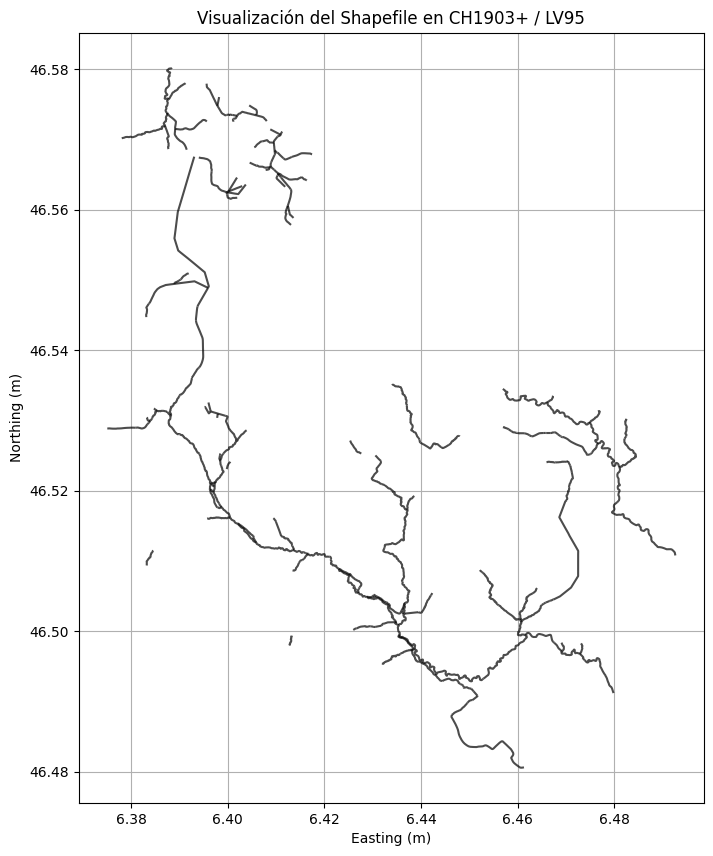

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
boiron.plot(ax=ax, edgecolor='k', alpha=0.7)
ax.set_title('Visualización del Shapefile en CH1903+ / LV95')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.grid(True)
plt.show()

In [35]:
boiron = gpd.read_file('../data/external/swissTLMboiron')

bounds = boiron.total_bounds
# Definir la resolución
resolution = 30
x_min, y_min, x_max, y_max = bounds
x_range = np.arange(x_min, x_max, resolution)
y_range = np.arange(y_min, y_max, resolution)

# Crear una cuadrícula
grid_points = [(x, y) for x in x_range for y in y_range]

#### 2. Assign river values to the grid

In [36]:
# Definir la transformación
transform = from_origin(x_min, y_max, resolution, resolution)  # Origen en la esquina superior izquierda

# Crear una máscara rasterizada
def rasterize_linestrings(lines, transform, out_shape):
    # Convertir a geometría de raster
    shapes = ((geom, 1) for geom in lines)
    mask = rasterize(shapes, out_shape=out_shape, transform=transform)
    return mask

# Convertir los LineStrings a una lista de geometrías para rasterizar
line_geometries = boiron.geometry.values

# Crear una máscara rasterizada
out_shape = (len(y_range), len(x_range))
raster_mask = rasterize_linestrings(line_geometries, transform, out_shape)

In [37]:
raster_array = np.zeros(out_shape)

# Asignar valores a la matriz en función de la máscara
for i, geom in enumerate(line_geometries):
    # Rasterizar la geometría con valores
    shape = (geom, i + 1)  # Asigna un valor único para cada línea
    temp_mask = rasterize([shape], out_shape=out_shape, transform=transform)
    raster_array += temp_mask

#### 3. Binarize the image for masking

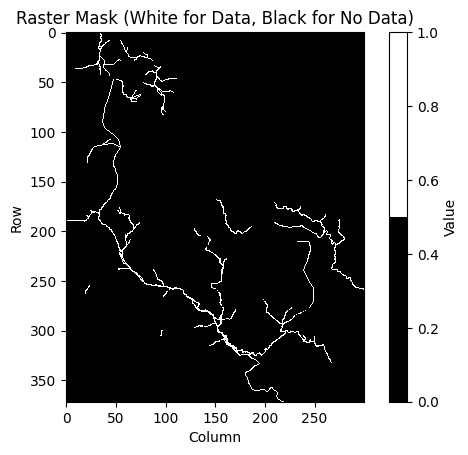

In [38]:
# Definir un colormap en blanco y negro
cmap = plt.cm.colors.ListedColormap(['black', 'white'])

# Crear una máscara binaria donde los valores no cero son 1 y el resto son 0
binary_mask = np.where(raster_array > 0, 1, 0)

# Mostrar la máscara rasterizada con el colormap personalizado
plt.imshow(binary_mask, cmap=cmap)
plt.colorbar(label='Value')
plt.title('Raster Mask (White for Data, Black for No Data)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [40]:
# Definir el perfil del raster
profile = {
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'uint8',  # Tipo de dato adecuado para imágenes en blanco y negro
    'width': raster_array.shape[1],
    'height': raster_array.shape[0],
    'crs': boiron.crs.to_string(),  # Usar CRS del shapefile
    'transform': transform,
    'nodata': 0,  # Asignar 0 para áreas sin datos
}

# Guardar el archivo rasterizado en blanco y negro
with rasterio.open('../data/external/raster_mask_bw.tif', 'w', **profile) as dst:
    dst.write(binary_mask, 1)


### Mask the water temperature data to Le Boiron river

 Quadrant mask to assign to its correspondent values

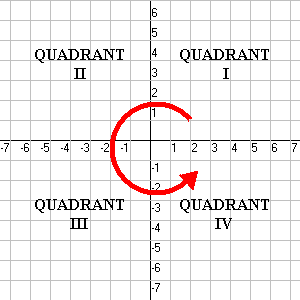

In [42]:
destination_folder = '../data/raw/wt/'
for file in os.listdir(destination_folder):
    if file.endswith('.tif'):
        os.remove(os.path.join(destination_folder, file))


In [44]:
dates = list(closest_points['upper_right']['time'].unique())
for d in dates:
    ur = closest_points['upper_right'][closest_points['upper_right'].time == d]
    ul = closest_points['upper_left'][closest_points['upper_left'].time == d]
    ll = closest_points['lower_left'][closest_points['lower_left'].time == d]
    lr = closest_points['lower_right'][closest_points['lower_right'].time == d]

    height, width = binary_mask.shape

    # Define los límites de los cuadrantes
    half_height = height // 2
    half_width = width // 2

    # Crea una máscara para cada cuadrante
    mask_q1 = np.zeros_like(binary_mask, dtype=np.float32)
    mask_q2 = np.zeros_like(binary_mask, dtype=np.float32)
    mask_q3 = np.zeros_like(binary_mask, dtype=np.float32)
    mask_q4 = np.zeros_like(binary_mask, dtype=np.float32)

    value_q1 = ur.waterTemperature  # Valor específico para el cuadrante 1
    value_q2 = ul.waterTemperature  # Valor específico para el cuadrante 2
    value_q3 = ll.waterTemperature  # Valor específico para el cuadrante 3
    value_q4 = lr.waterTemperature

    mask_q1[0:half_height, 0:half_width] = np.where(binary_mask[0:half_height, 0:half_width] > 0, value_q1, 0.0)
    mask_q2[0:half_height, half_width:] = np.where(binary_mask[0:half_height, half_width:] > 0, value_q2, 0.0)
    mask_q3[half_height:, 0:half_width] = np.where(binary_mask[half_height:, 0:half_width] > 0, value_q3, 0.0)
    mask_q4[half_height:, half_width:] = np.where(binary_mask[half_height:, half_width:] > 0, value_q4, 0.0)


    combined_mask = mask_q1 + mask_q2 + mask_q3 + mask_q4

    # Definir el perfil del raster
    profile = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': 'float32',  # Tipo de dato adecuado para imágenes en blanco y negro
        'width': combined_mask.shape[1],
        'height': combined_mask.shape[0],
        'crs': boiron.crs.to_string(),  # Usar CRS del shapefile
        'transform': transform,
        'nodata': 0.0,  # Asignar 0 para áreas sin datos
    }

    # Guardar el archivo rasterizado en blanco y negro
    with rasterio.open(f'{destination_folder}raster_mask_temp_{d.strftime("%Y-%m")}.tif', 'w', **profile) as dst:
        dst.write(combined_mask, 1)


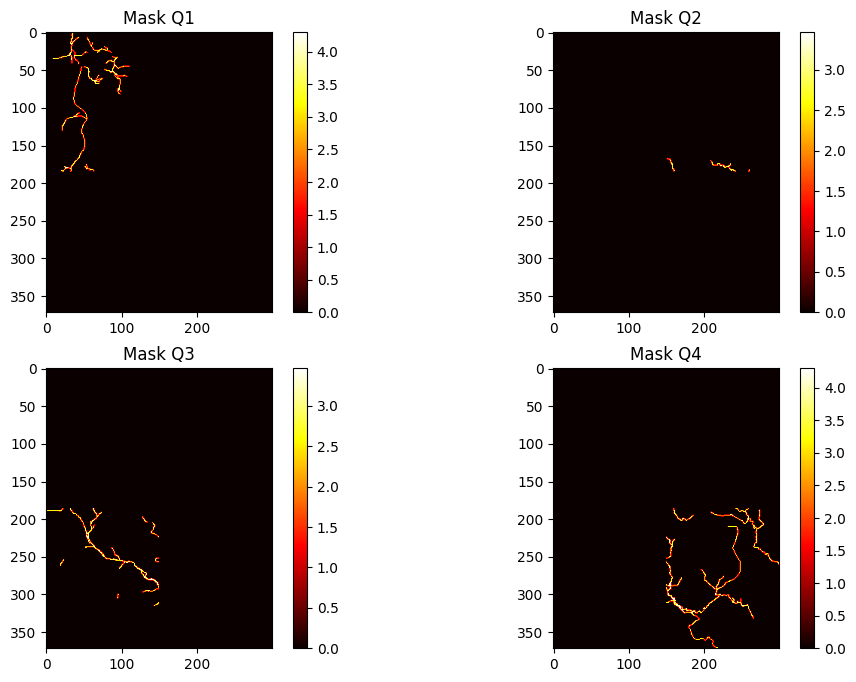

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('Mask Q1')
plt.imshow(mask_q1, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Mask Q2')
plt.imshow(mask_q2, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('Mask Q3')
plt.imshow(mask_q3, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('Mask Q4')
plt.imshow(mask_q4, cmap='hot')
plt.colorbar()

plt.show()


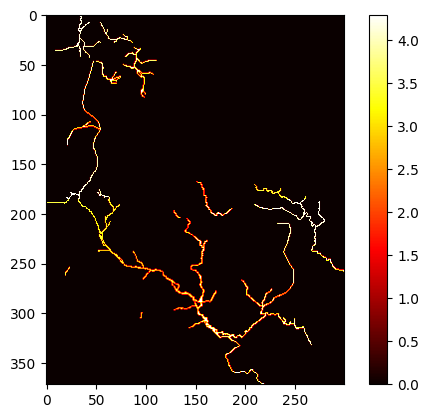

In [46]:
plt.imshow(combined_mask,cmap='hot')#, cmap='viridis')
plt.colorbar()
plt.show()

## Obtain NDVI images

In [52]:
# Exemple de BBOX sur le Boiron:
coords_wgs84 = [lon_min, lat_min, lon_max, lat_max]
resolution = 30

bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

# extract the size based on bbx and the resolution
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {size} pixels')

Image shape at 30 m resolution: (312, 359) pixels


In [55]:
def get_data_request(time_interval, evalscript):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.LANDSAT_OT_L1,
                time_interval=time_interval,
                mosaicking_order='leastCC',
                maxcc=0.1
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
            SentinelHubRequest.output_response('ndvi_image', MimeType.PNG)
        ],
        bbox=bbox,
        size=size,
        data_folder="../data/raw/ndvi",
        config=config
    )

In [48]:
evalscript_ndvi = """//VERSION=3

function setup() {
    return {

      input: [{
        bands: ["B04", "B05"],
      }],
      output: [{
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        },
        {
          id: "ndvi_image",
          bands: 3,
          sampleType: SampleType.AUTO
        }
      ]
    }
  }


  function evaluatePixel(sample) {
    let ndvi = (sample.B05 - sample.B04) / (sample.B05 + sample.B04)

    if (ndvi < -0.5) image = [0.05, 0.05, 0.05]
    else if (ndvi < -0.2) image = [0.75, 0.75, 0.75]
    else if (ndvi < -0.1) image = [0.86, 0.86, 0.86]
    else if (ndvi < 0) image = [0.92, 0.92, 0.92]
    else if (ndvi < 0.025) image = [1, 0.98, 0.8]
    else if (ndvi < 0.05) image = [0.93, 0.91, 0.71]
    else if (ndvi < 0.075) image = [0.87, 0.85, 0.61]
    else if (ndvi < 0.1) image = [0.8, 0.78, 0.51]
    else if (ndvi < 0.125) image = [0.74, 0.72, 0.42]
    else if (ndvi < 0.15) image = [0.69, 0.76, 0.38]
    else if (ndvi < 0.175) image = [0.64, 0.8, 0.35]
    else if (ndvi < 0.2) image = [0.57, 0.75, 0.32]
    else if (ndvi < 0.25) image = [0.5, 0.7, 0.28]
    else if (ndvi < 0.3) image = [0.44, 0.64, 0.25]
    else if (ndvi < 0.35) image = [0.38, 0.59, 0.21]
    else if (ndvi < 0.4) image = [0.31, 0.54, 0.18]
    else if (ndvi < 0.45) image = [0.25, 0.49, 0.14]
    else if (ndvi < 0.5) image = [0.19, 0.43, 0.11]
    else if (ndvi < 0.55) image = [0.13, 0.38, 0.07]
    else if (ndvi < 0.6) image = [0.06, 0.33, 0.04]
    else image = [0, 0.27, 0]

    return {
      default: [ndvi],
      ndvi_image: image
    }
  }"""

In [49]:
'''start_date = '2013-03'
end_date = '2023-07'

# Generar el rango de fechas en formato YYYY-MM
date_range = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m')

# Convertir a un array de numpy (opcional, si quieres un array en lugar de un pandas Index)
unique_dates = date_range.to_numpy()
unique_dates'''

array(['2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12', 

In [62]:
slots = []

for date in unique_dates:
  year = int(date.split('-')[0])
  month = int(date.split('-')[1])
  fd = first_day(month, year)
  ld = last_day(fd)
  slots.append( (fd.isoformat(), ld.isoformat()) )

slots

[('2011-01-01', '2011-01-31'),
 ('2011-02-01', '2011-02-28'),
 ('2011-03-01', '2011-03-31'),
 ('2011-04-01', '2011-04-30'),
 ('2011-05-01', '2011-05-31'),
 ('2011-06-01', '2011-06-30'),
 ('2011-07-01', '2011-07-31'),
 ('2011-08-01', '2011-08-31'),
 ('2011-09-01', '2011-09-30'),
 ('2011-10-01', '2011-10-31'),
 ('2011-11-01', '2011-11-30'),
 ('2011-12-01', '2011-12-31'),
 ('2012-01-01', '2012-01-31'),
 ('2012-02-01', '2012-02-29'),
 ('2012-03-01', '2012-03-31'),
 ('2012-04-01', '2012-04-30'),
 ('2012-05-01', '2012-05-31'),
 ('2012-06-01', '2012-06-30'),
 ('2012-07-01', '2012-07-31'),
 ('2012-08-01', '2012-08-31'),
 ('2012-09-01', '2012-09-30'),
 ('2012-10-01', '2012-10-31'),
 ('2012-11-01', '2012-11-30'),
 ('2012-12-01', '2012-12-31'),
 ('2013-01-01', '2013-01-31'),
 ('2013-02-01', '2013-02-28'),
 ('2013-03-01', '2013-03-31'),
 ('2013-04-01', '2013-04-30'),
 ('2013-05-01', '2013-05-31'),
 ('2013-06-01', '2013-06-30'),
 ('2013-07-01', '2013-07-31'),
 ('2013-08-01', '2013-08-31'),
 ('2013-

In [63]:
# create a list of requests
list_of_requests = [get_data_request(slot,evalscript_ndvi) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

#### Save images

In [64]:
import os
import shutil

# Ruta de la carpeta que contiene las subcarpetas
source_folder = '../data/raw/ndvi'
# Ruta de la carpeta donde se guardarán los archivos .tiff renombrados
destination_folder = '../data/raw/ndvi'
os.makedirs(destination_folder, exist_ok=True)

# Inicializa un contador para renombrar las imágenes
counter = 0

for file in os.listdir(destination_folder):
    if file.endswith('.tiff'):
        os.remove(os.path.join(destination_folder, file))

In [65]:
import os
import shutil
import tarfile

# Recorre todas las subcarpetas en la carpeta principal
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        # Si el archivo es un .tar
        if file.endswith('.tar'):
            # Construye la ruta completa del archivo tar
            tar_file_path = os.path.join(subdir, file)

            # Define el nuevo nombre de la carpeta donde se extraerán los archivos
            extract_folder_name = f'extracted_{slots[counter][0][:7]}'
            extract_folder_path = os.path.join(destination_folder, extract_folder_name)

            # Crea el directorio si no existe
            if not os.path.exists(extract_folder_path):
                os.makedirs(extract_folder_path)

            # Abre y descomprime el archivo .tar
            with tarfile.open(tar_file_path, 'r') as tar:
                tar.extractall(path=extract_folder_path)

            print(f'Archivo {file} descomprimido en {extract_folder_path}')

            # Busca el archivo .tif dentro de la carpeta descomprimida
            for root, dirs, extracted_files in os.walk(extract_folder_path):
                for extracted_file in extracted_files:
                    if extracted_file.endswith('.tif'):
                        # Ruta completa del archivo .tif
                        tiff_file_path = os.path.join(root, extracted_file)

                        # Define la ruta de destino fuera de la carpeta
                        new_tiff_file_path = os.path.join(destination_folder, extracted_file)

                        new_file_name = f'ndvi_{slots[counter][0][:7]}.tiff'
                        new_file_path = os.path.join(destination_folder, new_file_name)

                        # Mueve el archivo .tif fuera de la carpeta descomprimida
                        shutil.move(tiff_file_path, new_file_path)

                        print(f'Archivo {extracted_file} movido a {new_file_path}')

            # Incrementa el contador
            counter += 1


Archivo response.tar descomprimido en ../data/raw/ndvi/extracted_2011-01
Archivo default.tif movido a ../data/raw/ndvi/ndvi_2011-01.tiff
Archivo response.tar descomprimido en ../data/raw/ndvi/extracted_2011-02
Archivo default.tif movido a ../data/raw/ndvi/ndvi_2011-02.tiff
Archivo response.tar descomprimido en ../data/raw/ndvi/extracted_2011-03
Archivo default.tif movido a ../data/raw/ndvi/ndvi_2011-03.tiff
Archivo response.tar descomprimido en ../data/raw/ndvi/extracted_2011-04
Archivo default.tif movido a ../data/raw/ndvi/ndvi_2011-04.tiff
Archivo response.tar descomprimido en ../data/raw/ndvi/extracted_2011-05
Archivo default.tif movido a ../data/raw/ndvi/ndvi_2011-05.tiff
Archivo response.tar descomprimido en ../data/raw/ndvi/extracted_2011-06
Archivo default.tif movido a ../data/raw/ndvi/ndvi_2011-06.tiff
Archivo response.tar descomprimido en ../data/raw/ndvi/extracted_2011-07
Archivo default.tif movido a ../data/raw/ndvi/ndvi_2011-07.tiff
Archivo response.tar descomprimido en ../

In [66]:
for subdir, dirs, files in os.walk(source_folder):
    for dir in dirs:
        dir_path = os.path.join(subdir, dir)
        shutil.rmtree(dir_path, ignore_errors=True)